# need data for each game and final score

In [1]:
import requests
import pprint
import os
import json
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [153]:
seasons = list(range(2010,2011))
max_game_id = 1313 # 32 teams can play 82 games each ... 32*82/2 == 1312


for season in seasons:
    print(f'...scraping {season}-{str(season+1)[2:]}')
    # scrape games for this season
    games = []
    last_date = '' # in case some games do not record a startDate
    for game_id in range(1, max_game_id):
        try:
            r = requests.get(f'https://statsapi.web.nhl.com/api/v1/game/{season}02{str(game_id).zfill(4)}/linescore')
            d = r.json()

            szn = f'{season}-{str(season+1)[2:]}'
            try:
                date = d['periods'][0]['startTime']
                last_date = date
            except:
                date = last_date
            last_period = d['periods'][-1]
            last_period_type = last_period['periodType']
            home_team = d['teams']['home']['team']['name']
            away_team = d['teams']['away']['team']['name']
            home_goals = d['teams']['home']['goals']
            away_goals = d['teams']['away']['goals']
            games.append([szn, date, last_period_type, home_team, away_team, home_goals, away_goals])
        except:
            print('could not find gameId: ' + str(game_id))
            break
    df = pd.DataFrame(games)
    df.columns = ['season', 'date', 'period_type', 'home_team', 'away_team', 'home_goals', 'away_goals']
    
    # calculate which teams get points in game
    df['home_points'] = np.where(df['home_goals']>df['away_goals'], 2,
                                 np.where(df['period_type']=='OVERTIME', 1, 0))

    df['away_points'] = np.where(df['home_goals']<df['away_goals'], 2,
                                 np.where(df['period_type']=='OVERTIME', 1, 0))

    # convert datetime to date
    df['date'] = pd.to_datetime(df['date']).dt.date

    # alter dataframe to have 3 columns: date, team, and points 
    df_home = df[['season', 'date', 'home_team', 'home_points']]
    df_home.columns = ['season', 'date', 'team', 'points']
    df_away = df[['season', 'date', 'away_team', 'away_points']]
    df_away.columns = ['season', 'date', 'team', 'points']
    df = result = pd.concat([df_home, df_away]).sort_values('date')

    #########################################
    # scrape divisions for this season
    r = requests.get(f'https://statsapi.web.nhl.com/api/v1/teams?season={season}{season+1}')
    d = r.json()
    team_and_division = [[team['name'], team['division']['name'], team['conference']['name']] for team in d['teams']]
    df_divisions = pd.DataFrame(team_and_division)
    df_divisions.columns = ['team', 'division', 'conference']
    
    # merge division/conference for each team
    df.sort_values(by=['team', 'date'], inplace=True)
    df_divisions.sort_values(by=['team'], inplace=True)
    df = df.merge(df_divisions, how='left', on='team')
    
    #########################################
    df.to_csv(f'linescore/games{season}-{str(season+1)[2:]}.csv', index=False)
    print(f'scraped {len(df)} games')
    print()

...scraping 2010-11
could not find gameId: 1231
scraped 2460 games



# Concatenate all data and calculate metrics

In [2]:
li = []
filenames = [f'linescore/games{season}-{str(season+1)[2:]}.csv' for season in range(2011,2021)]

for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [3]:
df.head()

,season,date,team,points,division,conference
0,2011-12,2011-10-08,Anaheim Ducks,0,Pacific,Western
1,2011-12,2011-10-09,Anaheim Ducks,2,Pacific,Western
2,2011-12,2011-10-15,Anaheim Ducks,2,Pacific,Western
3,2011-12,2011-10-17,Anaheim Ducks,2,Pacific,Western
4,2011-12,2011-10-18,Anaheim Ducks,2,Pacific,Western


### calculate cumulative point totals and total percentage of points for any day

In [4]:
# get a cumulative sum of points for each team
df['cum_points'] = df.groupby(['season', 'team'])['points'].cumsum()

# get points percentage for each team
df['possible_points'] = [2] * len(df)
df['total_possible_points'] = df.groupby(['season', 'team'])['possible_points'].cumsum()
df['points_pct'] = df['cum_points'] / df['total_possible_points']

In [5]:
df = df[['season', 'date', 'team', 'division', 'conference', 'cum_points', 'points_pct']]
df['date'] = pd.to_datetime(df['date']) # change date to datetime format

In [6]:
df[df['team']=='Chicago Blackhawks']

,season,date,team,division,conference,cum_points,points_pct
410,2011-12,2011-10-08,Chicago Blackhawks,Central,Western,0,0.000000
411,2011-12,2011-10-09,Chicago Blackhawks,Central,Western,2,0.500000
412,2011-12,2011-10-14,Chicago Blackhawks,Central,Western,4,0.666667
413,2011-12,2011-10-16,Chicago Blackhawks,Central,Western,5,0.625000
414,2011-12,2011-10-19,Chicago Blackhawks,Central,Western,7,0.700000
...,...,...,...,...,...,...,...
21375,2020-21,2021-05-03,Chicago Blackhawks,Discover Central,Western,50,0.480769
21376,2020-21,2021-05-04,Chicago Blackhawks,Discover Central,Western,50,0.471698
21377,2020-21,2021-05-06,Chicago Blackhawks,Discover Central,Western,52,0.481481
21378,2020-21,2021-05-09,Chicago Blackhawks,Discover Central,Western,54,0.490909


### calculate point thresholds for playoff spots
* for each season
    * for each day
        * for each division/conference
            * get number of points held by last available playoff spot

In [7]:
# find cumulative points threshold for divisional playoff spot
def division_playoff_spot(season, date, division, df):
    cutoff = 2
    if season <= '2012-13':
        cutoff = 0
    elif season == '2020-21':
        cutoff = 3
    try:
        return df[(df['season']==season) &
                    (df['date'] <= date) &
                    (df['division']==division)] \
                    .sort_values(by='date', ascending=False) \
                    .drop_duplicates(subset = ["team"]) \
                    .sort_values(by='cum_points', ascending=False) \
                    .reset_index()['cum_points'][cutoff]
    except:
        return 0  # need this in start of season when less than 3 teams have played a game

# find cumulative points threshold for conference playoff spot
def conference_playoff_spot(season, date, conference, df):
    if season == '2020-21':
        return 0 # no conference playoff spots for this season
    try:
        return df[(df['season']==season) &
                    (df['date'] <= date) &
                    (df['conference']==conference)] \
                    .sort_values(by='date', ascending=False) \
                    .drop_duplicates(subset = ["team"]) \
                    .sort_values(by='cum_points', ascending=False) \
                    .reset_index()['cum_points'][7]
    except:
        return 0  # need this in start of season when less than 3 teams have played a game

In [16]:
thresholds = []
for season in df['season'].unique():
    for division in df[df['season']==season]['division'].unique():
        dates = np.arange(datetime(int(season[:4]),6,1), datetime(int(season[:4])+1,6,1), timedelta(days=1)).astype(datetime)
        for date in dates:
            thresholds.append([season, date, division, division_playoff_spot(season, date, division, df)])

    for conference in df[df['season']==season]['conference'].unique():
        dates = np.arange(datetime(int(season[:4]),6,1), datetime(int(season[:4])+1,6,1), timedelta(days=1)).astype(datetime)
        for date in dates:
            thresholds.append([season, date, conference, conference_playoff_spot(season, date, conference, df)])


In [17]:
df_thr = pd.DataFrame(thresholds)
df_thr.columns = ['season', 'date', 'div_conf_name', 'points_threshold']
df_thr

,season,date,div_conf_name,points_threshold
0,2011-12,2011-06-01,Pacific,0
1,2011-12,2011-06-02,Pacific,0
2,2011-12,2011-06-03,Pacific,0
3,2011-12,2011-06-04,Pacific,0
4,2011-12,2011-06-05,Pacific,0
...,...,...,...,...
23375,2020-21,2021-05-27,Eastern,0
23376,2020-21,2021-05-28,Eastern,0
23377,2020-21,2021-05-29,Eastern,0
23378,2020-21,2021-05-30,Eastern,0


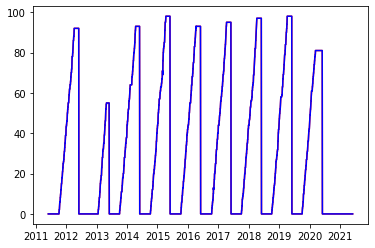

In [19]:
display(plt.plot(df_thr[df_thr['div_conf_name']=='Eastern']['date'], df_thr[df_thr['div_conf_name']=='Eastern']['points_threshold'], linestyle = 'solid', color='red'))
display(plt.plot(df_thr[df_thr['div_conf_name']=='Western']['date'], df_thr[df_thr['div_conf_name']=='Eastern']['points_threshold'], linestyle = 'solid', color='blue'))



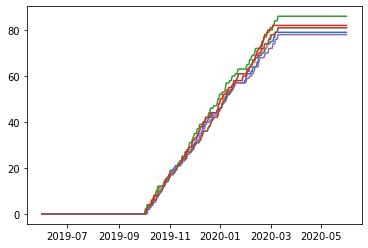

In [21]:
df_thr_tmp = df_thr[df_thr['season']=='2019-20']
for div in df_thr_tmp['div_conf_name'].unique():
    df_div = df_thr_tmp[df_thr_tmp['div_conf_name']==div]
    display(plt.plot(df_div['date'], df_div['points_threshold'], linestyle = 'solid'))


In [18]:
df_thr.to_csv(f'linescore/playoff_thresholds.csv', index=False)

### get team standings every day in year

In [49]:
def get_cum_points(date, team, df):
    try:
        return df[(df['date']==date) & (df['team']==team)]['cum_points'].reset_index()['cum_points'][0]
    except:
        return 0

In [95]:
standings = []
# season = '2020-21'
for season in df['season'].unique():
    for team in df[df['season']==season]['team'].unique():
        division = df[(df['season']==season) & (df['team']==team)].reset_index()['division'][0]
        conference = df[(df['season']==season) & (df['team']==team)].reset_index()['conference'][0]
        last_point_total = 0
        dates = np.arange(datetime(int(season[:4]),6,1), datetime(int(season[:4])+1,6,1), timedelta(days=1)).astype(datetime)
        for date in dates:
            this_day_points = get_cum_points(date, team, df)
            if this_day_points == 0:
                this_day_points = last_point_total
            else: 
                last_point_total = this_day_points
            standings.append([season, date, team, division, conference, this_day_points])

In [96]:
df_sta = pd.DataFrame(standings)
df_sta.columns = ['season', 'date', 'team', 'division', 'conference', 'points']

In [99]:
df_sta.to_csv(f'linescore/cumulative_points.csv', index=False)

In [100]:
df_sta

,season,date,team,division,conference,points
0,2011-12,2011-06-01,Anaheim Ducks,Pacific,Western,0
1,2011-12,2011-06-02,Anaheim Ducks,Pacific,Western,0
2,2011-12,2011-06-03,Anaheim Ducks,Pacific,Western,0
3,2011-12,2011-06-04,Anaheim Ducks,Pacific,Western,0
4,2011-12,2011-06-05,Anaheim Ducks,Pacific,Western,0
...,...,...,...,...,...,...
111046,2020-21,2021-05-27,Winnipeg Jets,Scotia North,Western,63
111047,2020-21,2021-05-28,Winnipeg Jets,Scotia North,Western,63
111048,2020-21,2021-05-29,Winnipeg Jets,Scotia North,Western,63
111049,2020-21,2021-05-30,Winnipeg Jets,Scotia North,Western,63


<AxesSubplot:xlabel='date'>

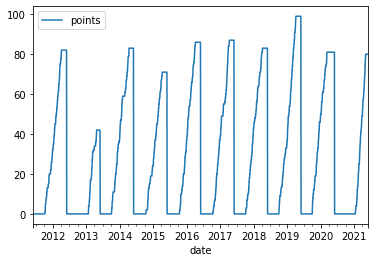

In [101]:
df_sta[df_sta['team']=='Carolina Hurricanes'].plot('date', 'points')

In [93]:
df_sta['division'].unique()

array(['Honda West', 'MassMutual East', 'Scotia North',
       'Discover Central'], dtype=object)

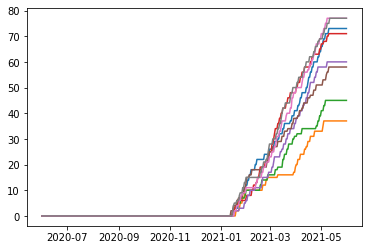

In [94]:
for team in df_sta[df_sta['division']=='MassMutual East']['team'].unique():
    plt.plot(df_sta[df_sta['team']==team]['date'], 
             df_sta[df_sta['team']==team]['points'], linestyle = 'solid')


# for team in df_div['team'].unique():
#     df_tmp = df_div[df_div['team']==team].sort_values(by='date').copy().reset_index()
#     plt.plot(df_tmp['date'], df_tmp['cum_points'], linestyle = 'solid')
# plt.show()

### other stuff i used previously

In [42]:
# find cumulative points threshold for divisional playoff spot
def division_playoff_spot(row, df):
    season = row.season
    date = row.date
    division = row.division
    cutoff = 2
    if row.season <= '2012-13':
        cutoff = 0
    elif row.season == '2020-21':
        cutoff = 3
    try:
        return df[(df['season']==season) &
                    (df['date'] <= date) &
                    (df['division']==division)] \
                    .sort_values(by='date', ascending=False) \
                    .drop_duplicates(subset = ["team"]) \
                    .sort_values(by='cum_points', ascending=False) \
                    .reset_index()['cum_points'][cutoff]
    except:
        return 0  # need this in start of season when less than 3 teams have played a game

# find cumulative points threshold for conference playoff spot
def conference_playoff_spot(row, df):
    season = row.season
    date = row.date
    conference = row.conference
    try:
        return df[(df['season']==season) &
                    (df['date'] <= date) &
                    (df['conference']==conference)] \
                    .sort_values(by='date', ascending=False) \
                    .drop_duplicates(subset = ["team"]) \
                    .sort_values(by='cum_points', ascending=False) \
                    .reset_index()['cum_points'][7]
    except:
        return 0  # need this in start of season when less than 3 teams have played a game



In [7]:
# 'learn' how many points a team is out of a divisional playoff spot on any day
df['division_threshold'] = [division_playoff_spot(row, df) for row in df.itertuples()]
df['points_above_division_spot'] = df['cum_points'] - df['division_threshold']

# 'learn' how many points a team is out of a conference playoff spot on any day
df['conference_threshold'] = [conference_playoff_spot(row, df) for row in df.itertuples()]
df['points_above_conference_spot'] = df['cum_points'] - df['conference_threshold']

### Save data to csv

In [12]:
df.to_csv(f'linescore/allGames2011-2021.csv', index=False)


### test with random team/season

In [8]:
df_team = df[(df['season']=='2019-20') & (df['team']=='Carolina Hurricanes')]
df_team

,season,date,team,points,division,conference,cum_points,possible_points,total_possible_points,points_pct,division_threshold,points_above_division_spot,conference_threshold,points_above_conference_spot
19174,2019-20,2019-10-03,Carolina Hurricanes,2,Metropolitan,Eastern,2,2,2,1.000000,2,0,0,2
19175,2019-20,2019-10-05,Carolina Hurricanes,2,Metropolitan,Eastern,4,2,4,1.000000,4,0,2,2
19176,2019-20,2019-10-06,Carolina Hurricanes,2,Metropolitan,Eastern,6,2,6,1.000000,4,2,3,3
19177,2019-20,2019-10-08,Carolina Hurricanes,2,Metropolitan,Eastern,8,2,8,1.000000,4,4,3,5
19178,2019-20,2019-10-11,Carolina Hurricanes,2,Metropolitan,Eastern,10,2,10,1.000000,4,6,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19237,2019-20,2020-03-01,Carolina Hurricanes,1,Metropolitan,Eastern,75,2,128,0.585938,80,-5,76,-1
19238,2019-20,2020-03-06,Carolina Hurricanes,0,Metropolitan,Eastern,75,2,130,0.576923,84,-9,78,-3
19239,2019-20,2020-03-07,Carolina Hurricanes,2,Metropolitan,Eastern,77,2,132,0.583333,84,-7,79,-2
19240,2019-20,2020-03-08,Carolina Hurricanes,2,Metropolitan,Eastern,79,2,134,0.589552,84,-5,79,0


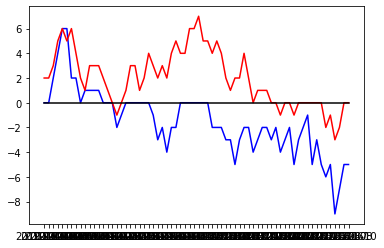

In [9]:
display(plt.plot(df_team['date'], df_team['points_above_division_spot'], linestyle = 'solid', color='blue'))
display(plt.plot(df_team['date'], df_team['points_above_conference_spot'], linestyle = 'solid', color='red'))
display(plt.plot(df_team['date'], [0] * len(df_team), linestyle = 'solid', color='black'))


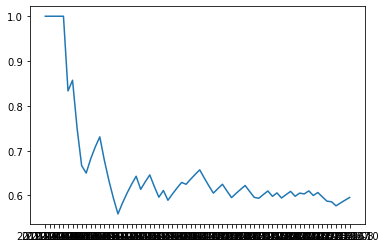

In [10]:
display(plt.plot(df_team['date'], df_team['points_pct'], linestyle = 'solid'))

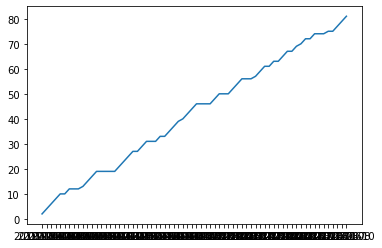

In [11]:
display(plt.plot(df_team['date'], df_team['cum_points'], linestyle = 'solid'))

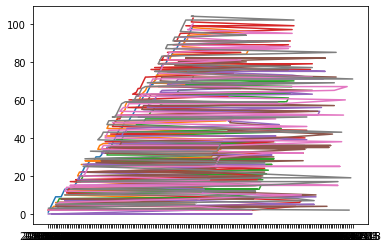

In [131]:
for team in df_div['team'].unique():
    df_tmp = df_div[df_div['team']==team].sort_values(by='date').copy().reset_index()
    plt.plot(df_tmp['date'], df_tmp['cum_points'], linestyle = 'solid')
plt.show()

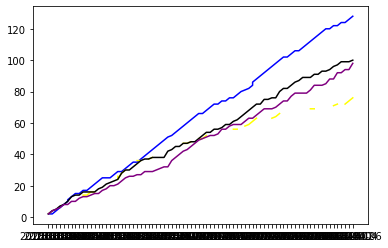

In [151]:
df_tmp = df[df['team']=='Tampa Bay Lightning'].sort_values(by='date')
df_tmp = df_tmp.merge(df[df['team']=='Buffalo Sabres'].sort_values(by='date'), how='left', on='date')
display(plt.plot(df_tmp['date'], df_tmp['cum_points_x'], linestyle = 'solid', color='blue'))
display(plt.plot(df_tmp['date'], df_tmp['cum_points_y'], linestyle = 'solid', color='yellow'))

display(plt.plot(df_tmp['date'], df_tmp['division_threshold_x'], linestyle = 'solid', color='black'))
display(plt.plot(df_tmp['date'], df_tmp['conference_threshold_x'], linestyle = 'solid', color='purple'))






In [148]:
df_tmp.merge(df[df['team']=='Boston Bruins'].sort_values(by='date'), how='left', on='date')


,season_x,date,team_x,points_x,division_x,conference_x,cum_points_x,possible_points_x,total_possible_points_x,points_pct_x,...,division_y,conference_y,cum_points_y,possible_points_y,total_possible_points_y,points_pct_y,division_threshold_y,points_above_division_spot_y,conference_threshold_y,points_above_conference_spot_y
0,2018-19,2018-10-06,Tampa Bay Lightning,2,Atlantic,Eastern,2,2,2,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-19,2018-10-11,Tampa Bay Lightning,0,Atlantic,Eastern,2,2,4,0.500000,...,Atlantic,Eastern,6.0,2.0,8.0,0.750000,4.0,2.0,4.0,2.0
2,2018-19,2018-10-13,Tampa Bay Lightning,2,Atlantic,Eastern,4,2,6,0.666667,...,Atlantic,Eastern,8.0,2.0,10.0,0.800000,5.0,3.0,5.0,3.0
3,2018-19,2018-10-16,Tampa Bay Lightning,2,Atlantic,Eastern,6,2,8,0.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-19,2018-10-18,Tampa Bay Lightning,2,Atlantic,Eastern,8,2,10,0.800000,...,Atlantic,Eastern,8.0,2.0,12.0,0.666667,8.0,0.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2018-19,2019-03-30,Tampa Bay Lightning,0,Atlantic,Eastern,122,2,156,0.782051,...,Atlantic,Eastern,103.0,2.0,156.0,0.660256,97.0,6.0,92.0,11.0
80,2018-19,2019-04-01,Tampa Bay Lightning,2,Atlantic,Eastern,124,2,158,0.784810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,2018-19,2019-04-02,Tampa Bay Lightning,0,Atlantic,Eastern,124,2,160,0.775000,...,Atlantic,Eastern,105.0,2.0,160.0,0.656250,99.0,6.0,94.0,11.0
82,2018-19,2019-04-04,Tampa Bay Lightning,2,Atlantic,Eastern,126,2,162,0.777778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df2 = pd.read_csv('linescore/allGames2010-2021.csv', index_col=None, header=0)

In [20]:
count = 0
for row in df.itertuples():
    while count < 10:
        print(row.division)
        count += 1
    

Pacific
Pacific
Pacific
Pacific
Pacific
Pacific
Pacific
Pacific
Pacific
Pacific
